In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import required packages.
import librosa
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile

### 1. Read speech data

In [3]:
# Set the directory path of the data directory.
# audio_path = './data/'
audio_path = ''
# Load a waveform.
xn_org, sf_org = librosa.load(audio_path+'Kim_16K.wav', sr=44100)
#sf, xn_org = wavfile.read(audio_path+'input.wav')

print(f'sampling rate : {sf_org}')
print(f'length of signal : {len(xn_org)/sf_org:.2f} seconds')

sampling rate : 44100
length of signal : 25.50 seconds


### 2. Plot and play the signal

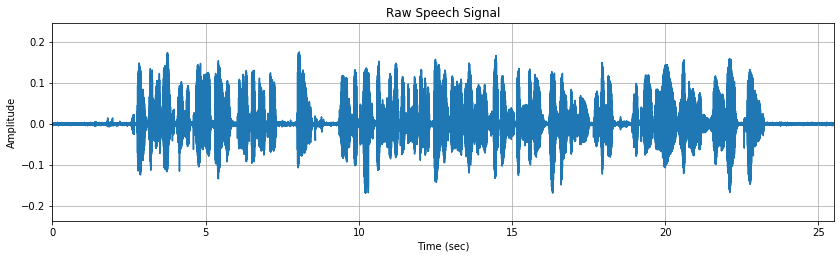

In [4]:
# Define a function to plot a time-domain signal.
def plot_signal(signal, sf):
    fig = plt.figure(figsize=(14, 8))
    ax = fig.add_subplot(211)
    ax.set_title('Raw Speech Signal')
    ax.set_xlabel('Time (sec)')
    ax.set_ylabel('Amplitude')
    ax.grid(True)
    N = len(signal)
    nx = np.linspace(0, N/sf, N)    
    ax.plot(nx, signal)
    ax.set_xlim(nx.min(), nx.max())
    ax.set_ylim(signal.min()*1.4, signal.max()*1.4)
    
    # Plot the designated time segment.
    # You will include codes here.
    
# Plot the signal.
plot_signal(xn_org, sf_org)

In [5]:
import IPython.display as ipd

# Play the speech signal.
ipd.Audio(xn_org, rate=sf_org)

### 3. Downsampling

In [6]:
# Perform downsampling to 16 and 8 kHz.
xn16khz = librosa.resample(xn_org, sf_org, 16000)
xn8khz = librosa.resample(xn_org, sf_org, 8000)

In [7]:
xn_length = len(xn_org)
xn16khz_length = len(xn16khz)
xn8khz_length = len(xn8khz)
print(xn_length, xn16khz_length, xn8khz_length)

1124550 408000 204000


### 4. Signal spectrum

In [8]:
# Choose the sampling frequency of input signal to process.
sampling_freq = 8000

# Choose an input signal depending on the pre-defined sampling frequency.
if sampling_freq == 44100:
    xn = xn_org    
elif sampling_freq == 16000:
    xn = xn16khz
elif sampling_freq == 8000:
    xn = xn8khz
else:
    print(f'Unsupported sampling frequency : {sampling_freq}')
    raise StopIteration

### 5. Cut short-time segment

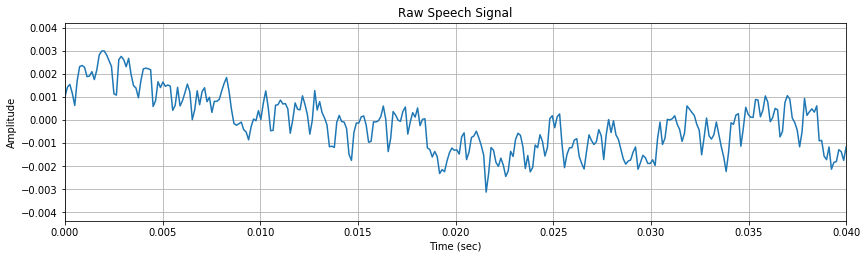

In [9]:
# Cut short-time segment.
def cut_segment(sn, start_position_second, sampling_rate, length_sec):
    nx = int(start_position_second * sampling_rate)
    ny = int(length_sec * sampling_rate)
    return sn[nx:nx+ny]

# Define the start time and length of signal (second) to use.
start_time, length = 0.7, 0.04
sn = cut_segment(xn, start_time, sampling_freq, length)

# Plot the segmented time domain signal.
plot_signal(sn, sampling_freq)

### 6. Magnitude spectrum

In [10]:
# fft_1d IMPLEMENTED BY MYSOLF, IT EQUIVALENTS TO THE RESULT FROM SCIPY 
from fft import fft_1d

In [11]:
# Perform FFT with a windowed signal.
sn_win = sn * np.hanning(len(sn))
fft_size = pow(2, int(np.log2(len(sn_win)))+1)
Sw = fft_1d(sn_win, fft_size)
print('fft_size: ', fft_size)
print('sn_win: ', len(sn_win))

# Compute magnitude and log-magnitude spectrum.
half_fft_size = int(fft_size / 2) + 1
mag_Sw = abs(Sw[:half_fft_size])
logmag_Sw = 20 * np.log10(mag_Sw)

fft_size:  512
sn_win:  320


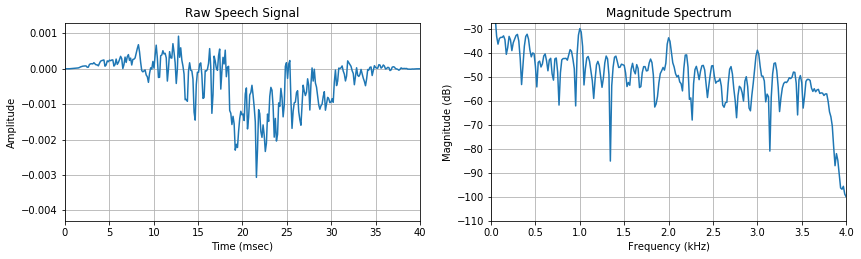

In [12]:
# Plot signal waveform and log-magnitude spectrum.
def plot_signal_spectrum(signal, logmag_sw, sf):
    fig = plt.figure(figsize=(14, 8))
    ax1 = fig.add_subplot(221)
    ax1.set_title('Raw Speech Signal')
    ax1.set_xlabel('Time (msec)')
    ax1.set_ylabel('Amplitude')
    ax1.grid(True)
    N = len(signal)
    nx = np.linspace(0, N/(sf*0.001), N)
    ax1.set_xlim(nx.min(), nx.max())
    ax1.set_ylim(signal.min()*1.4, signal.max()*1.4)    
    ax1.plot(nx, signal)
    
    ax2 = fig.add_subplot(222)
    ax2.set_title('Magnitude Spectrum')
    ax2.set_xlabel('Frequency (kHz)')
    ax2.set_ylabel('Magnitude (dB)')
    ax2.grid(True)
    NF = len(logmag_sw)
    nx2 = np.linspace(0, (sf/2*0.001), NF)
    ax2.set_xlim(nx2.min(), nx2.max())
    ax2.set_ylim(logmag_sw.min()*1.1, logmag_sw.max()*1.4)     
    ax2.plot(nx2, logmag_sw) 
    
# Plot the signal in the time and frequency domain.
plot_signal_spectrum(sn_win, logmag_Sw, sampling_freq)

### 7. Spectrogram

In [13]:
# fft_2d IMPLEMENTED BY MYSOLF, IT EQUIVALENTS TO THE RESULT FROM SCIPY
from fft import fft_2d

In [14]:
# Compute short time Fourier transformation (STFT).
def stft(sig, nfft, win_length_time, hop_length_time, fs, window_type='hann'):
    win_sample = int(win_length_time * fs)
    hop_sample = int(hop_length_time * fs)

    if window_type == 'hann':
        window = np.hanning(win_sample)
    elif window_type == 'hamming':
        window = np.hamming(win_sample)
    else:
        print('Wrong window type : {}'.format(window_type))
        raise StopIteration
        
    n_frames = int(np.floor((len(sig) - win_sample) / float(hop_sample)) + 1)
    frames = np.stack([window * sig[step*hop_sample : step*hop_sample + win_sample] for step in range(n_frames)])

    # SFFT IMPLEMENT BY MYSELF
    stft = fft_2d(frames, nfft)
    return stft

# Plot spectrogram.
def plot_spectrogram(spec, title, sr, type='spectrogram'):    
    plt.title(title)
    if type == 'spectrogram':
        ny = np.arange(0, spec.shape[-1], step=spec.shape[-1]/(sr//2000))
        ny_value = ["{}".format(int(x)) for x in np.arange(0,sr//2,1000)]
        plt.yticks(ny, ny_value)
        plt.ylabel('Frequency [Hz]')
    elif type == 'mel_spectrogram':
        plt.ylabel('The number of mel filterbanks')
    elif type == 'mfcc':
        plt.ylabel('The number of coefficients')
    plt.xlabel('The number of frames')
    plt.imshow(spec.transpose(), cmap='jet', origin='lowest', aspect='auto')
    plt.colorbar()
    plt.show()

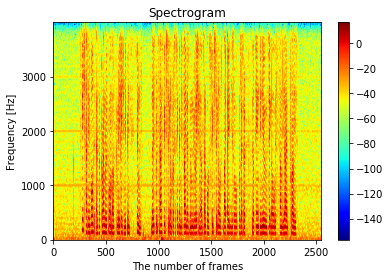

In [15]:
# Compute STFT for the input speech signal. 
nfft = 1024
frame_length = 0.04    # analysis frame length (seconds)
shift_length = 0.01    # shift length (seconds)
spectrogram = stft(xn, nfft, frame_length, shift_length, sampling_freq, 'hann')
mag = abs(spectrogram)
log_mag = 20 * np.log10(mag + 1.0e-10)

# Plot log-spectrogram.
plot_spectrogram(log_mag, 'Spectrogram', sampling_freq) 